# Basic text classification

- 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 binary 또는 class가 2개인 분류 문제입니다. 
- 여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용합니다.
- 25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있습니다.
- 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

* Train a binary classifier to perform sentiment analysis on an IMDB dataset.
* Train a multi-class classifier to predict the tag for a programming question on Stack Overflow.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.5.0


# Sentiment analysis
- This notebook trains a sentiment analysis model to classify movies as positive or negative, based on the text of the review.
- This is an example of binary-or two class-classification, an important and widely applicable kind of machine learning problem.

# Large Movie Review Dataset
- Contain the text of 50,000 movie reviews from the Internet Movie Database.
- These are split into 25,000 reviews for training and 25,000 reviews for testing.
- The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

# Download and explote the IMDB dataset

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Lobel", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Lobel 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset='validation',
                                                               seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                batch_size=batch_size)

Found 25000 files belonging to 2 classes.


* **Note**: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

# Prepare the dataset for training

In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization,
                                   max_tokens=max_features,
                                   output_mode='int',
                                   output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# The result of using this layer to preprocess some data

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configue the dataset for performance
* .cache()
* .prefetch()

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Crete the model

In [21]:
embedding_dim = 16

In [38]:
model = tf.keras.Sequential([layers.Embedding(max_features + 1, embedding_dim),
                            layers.Dropout(0.2),
                            layers.GlobalAveragePooling1D(),
                            layers.Dropout(0.2),
                            layers.Dense(1)])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


1. 첫 번째 층은 Embedding 층입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
2. 그다음 GlobalAveragePooling1D 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거칩니다.
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

#### Loss function and optimizer
- A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

In [25]:
# an optimizer and a loss function

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model
#### You will train the model by passing the dataset object to the fit method.

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6647 - binary_accuracy: 0.6945 - val_loss: 0.6158 - val_binary_accuracy: 0.7740
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5490 - binary_accuracy: 0.8034 - val_loss: 0.4982 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4448 - binary_accuracy: 0.8450 - val_loss: 0.4198 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3773 - binary_accuracy: 0.8662 - val_loss: 0.3734 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3347 - binary_accuracy: 0.8795 - val_loss: 0.3447 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3052 - binary_accuracy: 0.8887 - val_loss: 0.3256 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 2s 4ms/s

# Evaluate the model
####  Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

# This fairly naive approach achieves an accuracy of about 86%.

782/782 [==============================] - 10s 12ms/step - loss: 0.3105 - binary_accuracy: 0.8734
Loss:  0.3105130195617676
Accuracy:  0.8733999729156494


In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

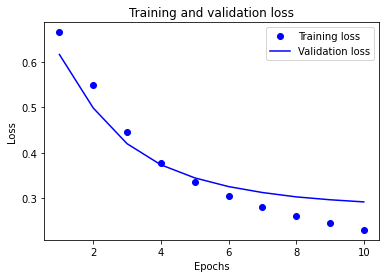

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

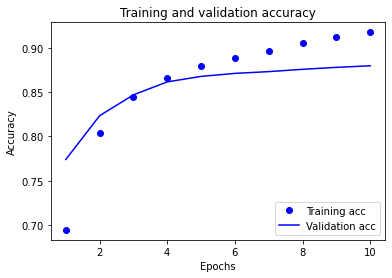

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

- 이 그래프에서 점선은 train loss와 train accuracy를 나타냅니다. 실선은 test loos와 test accuracy입니다.
- 훈련 손실은 epochs마다 감소하고 훈련 정확도는 증가한다는 것을 주목하세요. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다.
- 하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 약 20번째 에포크 이후가 최적점인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되기 어려운 훈련 데이터의 특정 표현을 학습합니다.
- 여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있습니다. 나중에 콜백(callback)을 사용하여 자동으로 이렇게 하는 방법을 배워 보겠습니다.

# Export the model
- Apply the TextVectorization layer to the dataset

In [35]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3105 - accuracy: 0.8734
0.8733999729156494


# Inference on new data
- To get predictions for new examples, you can simply call model.predict().

In [36]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]

export_model.predict(examples)

array([[0.5982661 ],
       [0.41843858],
       [0.33950675]], dtype=float32)

## Hidden Unit(은닉 유닛)
- 위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 층이 있습니다.
- 출력(유닛 또는 노드, 뉴런)의 개수는 층이 가진 표현 공간(representational space)의 차원이 됩니다. 다른 말로 하면, 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양입니다.
- 모델에 많은 은닉 유닛(고차원의 표현 공간)과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 그렇지 못합니다. 이를 과대적합(overfitting)이라고 부릅니다. 나중에 이에 대해 알아 보겠습니다.